<a href="https://colab.research.google.com/github/from1pandas-importLove/dbis1/blob/master/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Nelder-Mead method

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import sympy as sym
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sym.init_printing()


In [0]:
x = sym.Symbol('x')
y = sym.Symbol('y')

target_function = (10*(x-y)**2 + (x-1)**2 )**(1/4)
constraint_function = x + y < 1

# Target function

In [4]:
target_function

# Constraint function

In [5]:
constraint_function

In [0]:
f = sym.lambdify([x, y], target_function, 'numpy')
f_constraint = sym.lambdify([x, y], constraint_function, 'numpy')

In [0]:
n = 3
eps = 1e-6 # Accuracy
alpha = 1 # Reflection
beta = 0.5 # Contraction
gamma = 2 # Expansion
delta = 0.5 # Shrink

# Functions for our algorythm

In [0]:
def centroid(b,d):
    return (b+d)/2

In [0]:
def reflection(c, xh, alpha):
    return c + alpha*(c-xh)

In [0]:
def expansion(c, gamma, xr):
    return c + gamma*(xr-c)

In [0]:
def contraction(c, beta, xh):
    return c + beta*(xh-c)

In [0]:
def shrink(xl, delta, xj):
    return xl + delta * (xj-xl)

In [0]:
def order(a,col=2):
    return a[a[:,col].argsort()]

In [0]:
def get_triangle(a):
    x1 = a[0,0]
    y1 = a[0,1]
    
    x2 = a[1,0]
    y2 = a[1,1]
    
    x3 = a[2,0]
    y3 = a[2,1]
    return [(x1,y1),(x2,y2),(x3,y3)]

In [0]:
def get_triangle_coord(triangle,coord):
    return [triangle[0][coord],triangle[1][coord],triangle[2][coord]]

In [0]:
def plot_propagation(triangles,x_range,y_range,f,f_constraint):
    
    x, y = np.meshgrid(np.linspace(x_range[0], x_range[1], (x_range[1]-x_range[0])*100),
                   np.linspace(y_range[0], y_range[1], (y_range[1]-y_range[0])*100))

    fig, ax = plt.subplots(1,figsize=(20, 10))
    C1 = ax.contour(x, y, f(x, y))
    
    C2 = plt.contour(x,y,f_constraint(x,y),[0],colors='red')
    plt.clabel(C2, inline=1, fontsize=10)
    C2.collections[0].set_label('Constraint')
    plt.legend(loc='upper left')
    
    for i in range(len(triangles)):
        x_tri = get_triangle_coord(triangles[i],0)
        y_tri = get_triangle_coord(triangles[i],1)
        triang = mtri.Triangulation(x_tri, y_tri)
        plt.triplot(triang, marker="*")

In [0]:
def Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-1,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=True, max_iter=200, c_flag = True):
    xx = np.array([X_0[0][0],X_0[1][0],X_0[2][0]])
    yy = np.array([X_0[0][1],X_0[1][1],X_0[2][1]])
    ff = np.array([f(xx[0],yy[0]), f(xx[1],yy[1]), f(xx[2],yy[2])])
                               
    a = np.array([[xx[0],yy[0],ff[0]],[xx[1],yy[1],ff[1]],[xx[2],yy[2],ff[2]]])
    a = order(a)
    flag = True
    n_iter = 0
    triangles = []
    
    while flag:
        n_iter = n_iter +1
        a = order(a)
        #print('a = ', a)
        #print('\nfun = ', f(a[0][0], a[0][1]))
        tri_i = get_triangle(a)
        triangles.append(tri_i)
        points = triangles[n_iter - 1][0]
        if print_flag:
                print('iteration: {n_iter}\t  [x, y] = {points}\n  f(x, y) = {value}\n\n '.format(points=points, n_iter=n_iter, value=f(points[0],points[1])))
        if c_flag == True:
            if f_constraint(a[0][0], a[0][1]) == False:
                a[0][2] = 10 ** 10
            if abs( (a[0][2] - a[1][2] )) < eps:
                flag = False
                break
        elif abs( (a[0][2] - a[1][2] )) < eps:
            flag = False
            break
            
            
        xx_0 = centroid(a[0,0],a[1,0])
        yy_0 = centroid(a[0,1],a[1,1])

        xx_r = reflection(xx_0, a[2,0], alpha)
        yy_r = reflection(yy_0, a[2,1], alpha)
        ff_r = f(xx_r,yy_r)
        nr  = np.array([xx_r,yy_r,ff_r])

        a_n = np.vstack([a, nr])
        a_n = order(a_n)
        if ff_r == a_n[1,2]:
            a = np.delete(a, 2, 0)
            a = np.vstack([a, nr])
            continue
        elif ff_r == a_n[0,2]:
            xx_e = expansion(xx_0, gamma, xx_r)
            yy_e = expansion(yy_0, gamma, yy_r)
            ff_e = f(xx_e,yy_e)
            if ff_e < ff_r:
                nr_e = np.array([xx_e,yy_e,ff_e])
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_e])
                continue
            else:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr]) 
                continue
        elif ff_r >= a[1,2]:
            xx_c = contraction(xx_0,beta,a[2,0])
            yy_c = contraction(yy_0,beta,a[2,1])
            ff_c = f(xx_c,yy_c)
            nr_c = np.array([xx_c,yy_c,ff_c])
            if ff_c < a[2,2]:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_c])
                continue
        if n_iter>max_iter:
            flag = False
            break
        a = order(a)
        xx_s_1 = shrink(a[1,0], delta,a[0,0] )
        yy_s_1 = shrink(a[1,1], delta,a[0,1] )
        ff_s_1 = f(xx_s_1,yy_s_1)
        nr_1 = np.array([xx_s_1,yy_s_1,ff_s_1])
        xx_s_2 = shrink(a[2,0], delta,a[0,0] )
        yy_s_2 = shrink(a[2,1], delta,a[0,1] )
        ff_s_2 = f(xx_s_2,yy_s_2)
        nr_2 = np.array([xx_s_2,yy_s_2,ff_s_2])
        a = np.delete(a,a.shape[0]-1, 0)
        a = np.delete(a,a.shape[0]-1, 0)
        a = np.vstack([a, nr_1])
        a = np.vstack([a, nr_2])
        a = order(a)
        if n_iter > 200:
            break
    if plot_flag:

        x_tri = []
        y_tri = []
        for i in range(len(triangles)):
            x_tri.extend(get_triangle_coord(triangles[i],0))
            y_tri.extend(get_triangle_coord(triangles[i],1))
        x_min = min(x_tri)-0.5*abs(min(x_tri))
        x_max = max(x_tri)+0.5*abs(max(x_tri))
        y_min = min(y_tri)-0.5*abs(min(y_tri))
        y_max = max(y_tri)+0.5*abs(max(y_tri))
        plot_propagation(triangles,[int(np.floor(x_min)),int(np.ceil(x_max))],[int(np.floor(y_min)),int(np.ceil(y_max))],f,f_constraint)
    return a[0, :], n_iter, triangles

# Without constraint

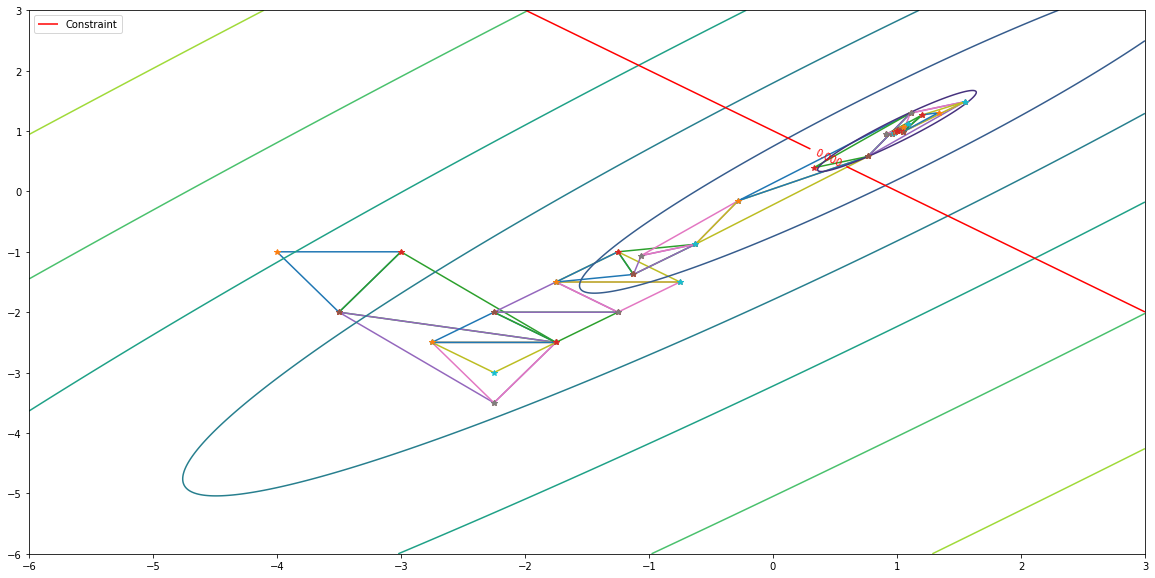

In [18]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal, n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=eps,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=False
                                 ,plot_flag=True, max_iter=100, c_flag=False)

# Point of min with value of the target function

In [19]:
optimal

array([1.00000000e+00, 1.00000000e+00, 8.33304516e-06])

# Number of iterations

In [20]:
n_iter

# History

In [21]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal, n_iter, history= Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=eps,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=False, max_iter=200, c_flag=False)

iteration: 1	  [x, y] = (-3.5, -2.0)
  f(x, y) = 2.557019439760091

 
iteration: 2	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 3	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 4	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 5	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 6	  [x, y] = (-2.25, -2.0)
  f(x, y) = 1.8288717943215465

 
iteration: 7	  [x, y] = (-1.25, -2.0)
  f(x, y) = 1.808085785480187

 
iteration: 8	  [x, y] = (-1.75, -1.5)
  f(x, y) = 1.6915616410775278

 
iteration: 9	  [x, y] = (-1.75, -1.5)
  f(x, y) = 1.6915616410775278

 
iteration: 10	  [x, y] = (-1.25, -1.0)
  f(x, y) = 1.5442953096938306

 
iteration: 11	  [x, y] = (-1.125, -1.375)
  f(x, y) = 1.505753845554489

 
iteration: 12	  [x, y] = (-0.625, -0.875)
  f(x, y) = 1.3442856976290867

 
iteration: 13	  [x, y] = (-0.625, -0.875)
  f(x, y) = 1.3442856976290867

 
iteration: 14	  [x, y] = (-0.28125, -0.15625)
  f(x, y)

# With line constraint x + y < 1

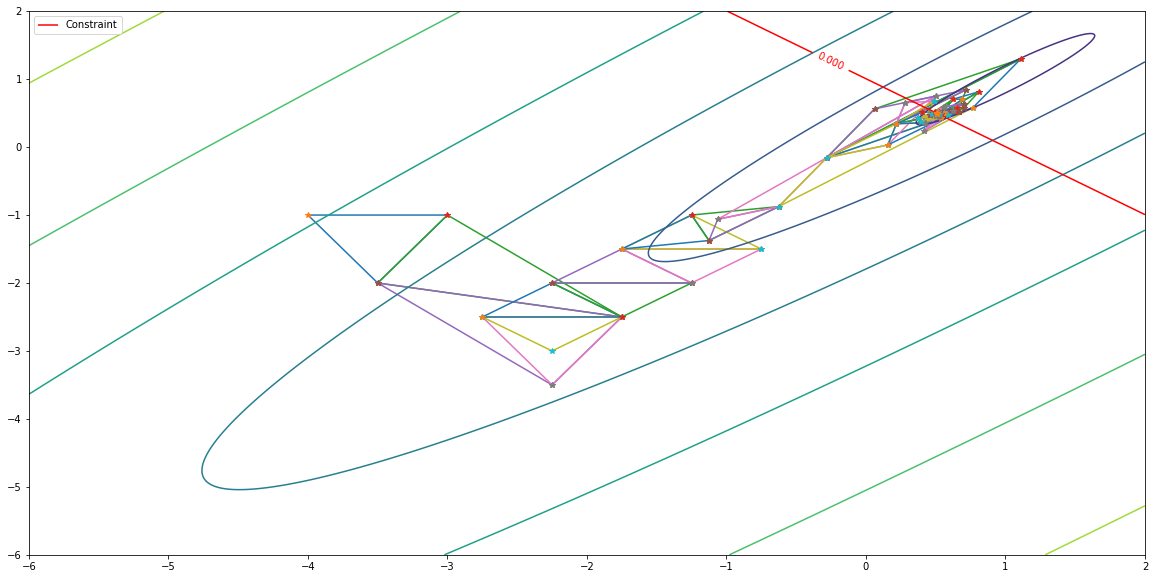

In [22]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal,n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-4,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=False,plot_flag=True, max_iter=100, c_flag=True)

# Number of iterations

In [23]:
n_iter

# Point of min with value of the target function

In [24]:
optimal

array([0.51133713, 0.48741524, 0.70319523])

# Validation of our points

In [25]:
f_constraint(0.51133713, 0.48741524)

True

# History

In [26]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal,n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-4,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=False, max_iter=100, c_flag=True)

iteration: 1	  [x, y] = (-3.5, -2.0)
  f(x, y) = 2.557019439760091

 
iteration: 2	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 3	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 4	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 5	  [x, y] = (-1.75, -2.5)
  f(x, y) = 1.9056389378850043

 
iteration: 6	  [x, y] = (-2.25, -2.0)
  f(x, y) = 1.8288717943215465

 
iteration: 7	  [x, y] = (-1.25, -2.0)
  f(x, y) = 1.808085785480187

 
iteration: 8	  [x, y] = (-1.75, -1.5)
  f(x, y) = 1.6915616410775278

 
iteration: 9	  [x, y] = (-1.75, -1.5)
  f(x, y) = 1.6915616410775278

 
iteration: 10	  [x, y] = (-1.25, -1.0)
  f(x, y) = 1.5442953096938306

 
iteration: 11	  [x, y] = (-1.125, -1.375)
  f(x, y) = 1.505753845554489

 
iteration: 12	  [x, y] = (-0.625, -0.875)
  f(x, y) = 1.3442856976290867

 
iteration: 13	  [x, y] = (-0.625, -0.875)
  f(x, y) = 1.3442856976290867

 
iteration: 14	  [x, y] = (-0.28125, -0.15625)
  f(x, y)

In [0]:
constraint_function = (x**2 + y**2) < 0.9
f_constraint = sym.lambdify([x, y], constraint_function, 'numpy')

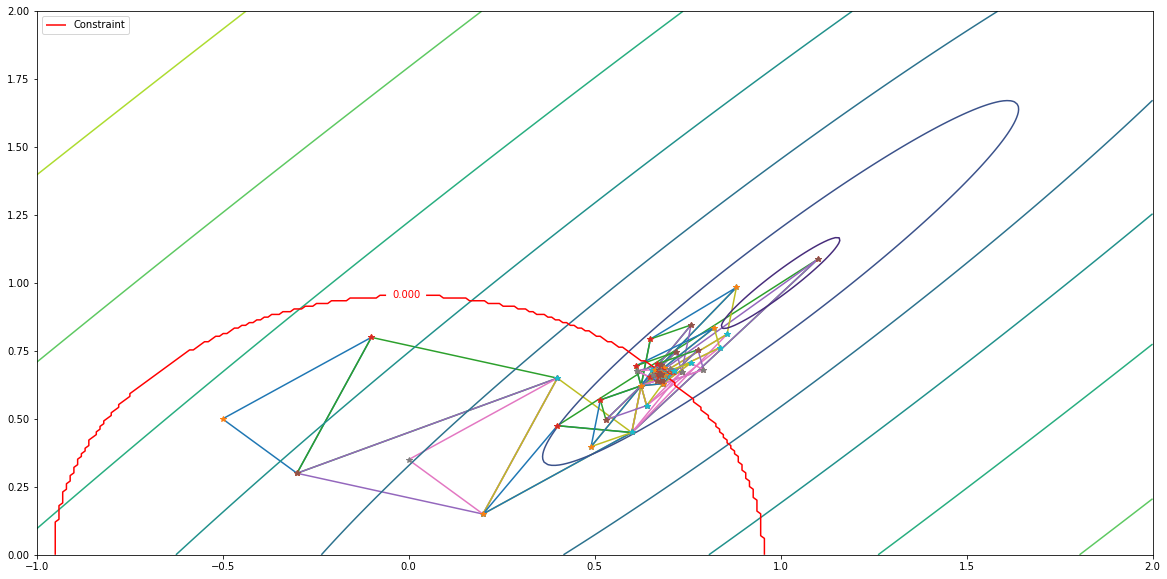

In [30]:
X_0 = [(-0.5, 0.5),(-0.3, 0.3),(-0.1, 0.8)]
optimal,n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-4,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=False,plot_flag=True, max_iter=100, c_flag=True)

In [32]:
X_0 = [(-0.5, 0.5),(-0.3, 0.3),(-0.1, 0.8)]
optimal,n_iter, history = Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-4,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=False, max_iter=100, c_flag=True)

iteration: 1	  [x, y] = (-0.3, 0.3)
  f(x, y) = 1.5165750888103102

 
iteration: 2	  [x, y] = (0.39999999999999997, 0.6500000000000001)
  f(x, y) = 0.9962287197546359

 
iteration: 3	  [x, y] = (0.19999999999999998, 0.15000000000000013)
  f(x, y) = 0.9030367221298392

 
iteration: 4	  [x, y] = (0.19999999999999998, 0.15000000000000013)
  f(x, y) = 0.9030367221298392

 
iteration: 5	  [x, y] = (0.6, 0.4500000000000002)
  f(x, y) = 0.7877078660896706

 
iteration: 6	  [x, y] = (0.6, 0.4500000000000002)
  f(x, y) = 0.7877078660896706

 
iteration: 7	  [x, y] = (1.1, 1.0875000000000001)
  f(x, y) = 0.32791624820681403

 
iteration: 8	  [x, y] = (0.625, 0.6218750000000002)
  f(x, y) = 0.6124787226798705

 
iteration: 9	  [x, y] = (0.8562500000000001, 0.8117187500000002)
  f(x, y) = 0.4485890840506531

 
iteration: 10	  [x, y] = (0.8812500000000002, 0.9835937500000003)
  f(x, y) = 0.5871435709082324

 
iteration: 11	  [x, y] = (0.625, 0.6218750000000002)
  f(x, y) = 0.6124787226798705

 
ite

In [33]:
f_constraint(0.6769995388185632, 0.6638536591433423 )

True